In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from dateutil.relativedelta import relativedelta as rd

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, and_, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c)

{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}


In [11]:
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print(c)

{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'longitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'elevation', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}


# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

## For the purposes of this exercise, I looked up if a leap year was involved in the calculation 
## and it wasn't; I did read about another module called dateutil that has a relative delta that more
## simply handles leap years. If for some reason dateutil doesn't work for you (it's a third party module
## but seems to be installed in this jupyter notebook), please see my commented out code below
## in this block: 

latest_date = session.query(func.max(Measurement.date)).all()
latest_date = list(np.ravel(latest_date))
latest_date = ''.join(latest_date)
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')

## calculation using datetime one_year_ago = latest_date - dt.timedelta(days=366)

# calculation using dateutil (the days value accounts for including all values on aug 23rd, 2016 to match
# the graph and summary statistics included in the sample file)
one_year_ago = latest_date + rd(years=-1, days=-1)
one_year_ago

datetime.datetime(2016, 8, 22, 0, 0)

In [13]:
# Perform a query to retrieve the date and precipitation scores
date_precip_data = session.query(Measurement.date, Measurement.prcp).\
filter(and_(Measurement.date <= latest_date, Measurement.date >= one_year_ago)).all()

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
date_precip_df = pd.DataFrame(date_precip_data, columns=['date', 'precipitation'])
date_precip_df.set_index('date', inplace=True)

In [15]:
# Sort the dataframe by date
date_precip_df = date_precip_df.sort_values(by=['date'], ascending=True)

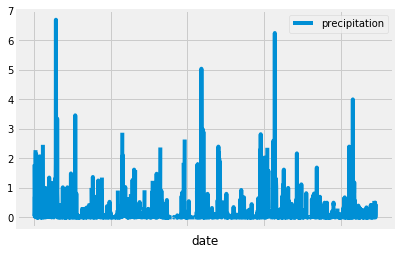

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
date_precip_df.plot()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [18]:
# Design a query to show how many stations are available in this dataset?
stations_data = session.query(func.count(Station.id)).all()
stations_data

[(9)]

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station_temps = session.query(func.min(Measurement.tobs),\
func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_active_station_temps

(54.0, 85.0, 71.66378066378067)

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Set variable for most active station
most_active_station = session.query(Measurement.station).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_active_station = list(np.ravel(most_active_station))
most_active_station = ''.join(most_active_station)

In [22]:
# Calculate latest date for most active station
latest_date = session.query(func.max(Measurement.date)).\
filter(Measurement.station == most_active_station).all()
latest_date = list(np.ravel(latest_date))
latest_date = ''.join(latest_date)
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')

In [23]:
# Calculate one year before latest date for most active station using dateutil (the days value accounts
# for including all values)
one_year_ago = latest_date + rd(years=-1, days=-1)

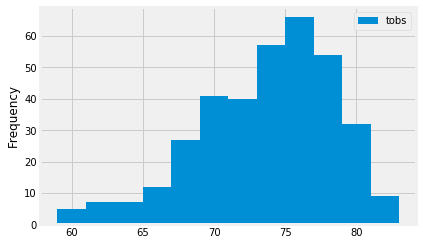

In [24]:
last_12_mon_most_active = session.query(Measurement.tobs, Measurement.date).\
filter(and_(Measurement.date <= latest_date, Measurement.date >= one_year_ago, Measurement.station == most_active_station)).all()
last_12_mon_most_active_temps_df = pd.DataFrame(last_12_mon_most_active, columns=['tobs', 'frequency'])
ax = last_12_mon_most_active_temps_df.hist(bins=12)
ax = ax[0]
for x in ax: 
    x.set_ylabel("Frequency")
    x.legend(["tobs"])
    x.set_title('')

![precipitation](Images/station-histogram.png)

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-03-13', '2016-03-28'))

[(63.0, 70.82291666666667, 82.0)]


Text(0.5,1,'Trip Avg Temp')

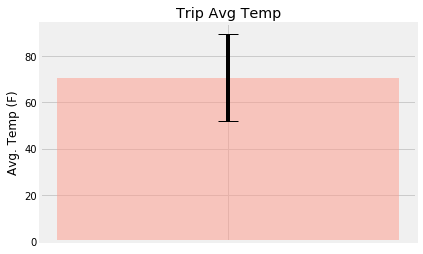

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temps = calc_temps('2016-03-13', '2016-03-28')
trip_temps = list(np.ravel(trip_temps))

x = ""
y = trip_temps[1]
y_error = (trip_temps[2]-trip_temps[0])

fig, ax = plt.subplots()
ax.bar(x, y, yerr= y_error, align='center', color = '#ff9a8a', alpha=0.5, capsize=10, ecolor = 'k')
ax.set_ylabel('Avg. Temp (F)')
ax.set_title('Trip Avg Temp')

In [28]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2016-03-13'
end_date = '2016-03-28'
sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation]

rainfall_by_station = session.query(*sel, (func.sum(Measurement.prcp))).filter(Measurement.station == Station.station).\
filter(and_(Measurement.date >= start_date, Measurement.date <= end_date)).group_by(Measurement.station).\
order_by(desc(func.sum(Measurement.prcp))).all()
rainfall_by_station

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 5.42),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  2.29),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  2.08),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.6800000000000002),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  1.11),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.24000000000000002),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]

## Optional Challenge Assignment

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start_date = '2017-03-13'
end_date = '2017-03-28'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start='3/13/2017', end='3/28/2017')

# Strf off the year and save a list of %m-%d strings
trip_dates_m_d = trip_dates.strftime("%m-%d")

# Loop through the list of %m-%d strings and calculate the normals for each date
for x in trip_dates_m_d:
    y = list(np.ravel(daily_normals(x)))
    normals.append(y)
    
normals

[[56.0, 69.29629629629629, 77.0],
 [62.0, 70.32758620689656, 77.0],
 [58.0, 68.54716981132076, 76.0],
 [60.0, 69.70370370370371, 78.0],
 [57.0, 68.54, 75.0],
 [57.0, 67.7843137254902, 76.0],
 [60.0, 69.1, 75.0],
 [62.0, 70.11764705882354, 80.0],
 [60.0, 71.07692307692308, 77.0],
 [65.0, 71.75471698113208, 77.0],
 [63.0, 70.79629629629629, 78.0],
 [62.0, 71.5, 77.0],
 [63.0, 71.5, 78.0],
 [64.0, 71.38, 80.0],
 [63.0, 71.53846153846153, 80.0],
 [59.0, 71.51785714285714, 82.0]]

In [32]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_columns = ['tmin', 'tavg', 'tmax']
normals_df = pd.DataFrame((normals), columns = df_columns)
dates_to_add = pd.Series(trip_dates_m_d)
normals_df['date'] = dates_to_add.values
normals_df = normals_df.set_index('date')

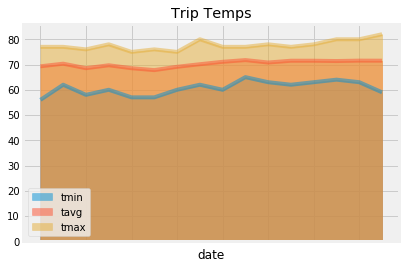

In [33]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind = 'area', stacked=False, title = "Trip Temps")